In [1]:
import torch
import numpy as np
from torch.nn import Parameter
from control_stork import activations, initializers
from control_stork.nodes import CellGroup
from typing import Optional, Tuple, List
import matplotlib.pyplot as plt

In [2]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

device = get_device()
print(device)

mps


In [3]:
class ALIFGroup(CellGroup):
    def __init__(
        self,
        shape,
        tau_mem=10e-3,
        tau_syn=5e-3,
        tau_ada=200e-3,
        threshold=1.0,
        threshold_decay=0.0,
        threshold_xi=0.0,
        learn_mem:bool=False,
        learn_syn:bool=False,
        learn_ada:bool=False,
        learn_param:str='tau',
        mem_param:str='full',
        syn_param:str='full',
        ada_param:str='full',
        reset:str='sub',
        diff_reset:bool=False,
        activation=activations.SigmoidSpike,
        dropout_p:float=0.0,
        stateful:bool=False,
        name:str="ALIFGroup",
        regularizers:Optional[list]=None,
        **kwargs
    ):

        super(ALIFGroup, self).__init__(
            shape,
            dropout_p=dropout_p,
            stateful=stateful,
            name=name,
            regularizers=regularizers,
            spiking=True,
            **kwargs
        )

        self.tau_mem_init = torch.Tensor([tau_mem]) if not torch.is_tensor(tau_mem) else tau_mem
        self.tau_syn_init = torch.Tensor([tau_syn]) if not torch.is_tensor(tau_syn) else tau_syn
        self.tau_ada_init = torch.Tensor([tau_ada]) if not torch.is_tensor(tau_ada) else tau_ada
        self.threshold = threshold
        self.threshold_decay = torch.Tensor([threshold_decay]) if not torch.is_tensor(threshold_decay) else threshold_decay
        assert torch.all(self.threshold_decay >= 0.0), "threshold_decay must be non-negative"
        self.threshold_xi = torch.Tensor([threshold_xi]) if not torch.is_tensor(threshold_xi) else threshold_xi
        assert torch.all(self.threshold_xi >= 0.0), "threshold_xi must be non-negative"
        self.learn_mem = learn_mem
        self.learn_syn = learn_syn
        self.learn_ada = learn_ada
        self.learn_param = learn_param
        self.mem_param = mem_param.lower()
        assert self.mem_param in ["full", "single"], "mem_param must be either 'full' or 'single'"
        if self.mem_param == 'single':
            assert self.tau_mem_init.shape == (1,), "tau_mem must be a scalar or a tensor of shape (1,) if mem_param is 'single'"
        self.syn_param = syn_param.lower()
        assert self.syn_param in ["full", "single"], "syn_param must be either 'full' or 'single'"
        if self.syn_param == 'single':
            assert self.tau_syn_init.shape == (1,), "tau_syn must be a scalar or a tensor of shape (1,) if syn_param is 'single'"
        self.ada_param = ada_param.lower()
        assert self.ada_param in ["full", "single"], "ada_param must be either 'full' or 'single'"
        if self.ada_param == 'single':
            assert self.tau_ada_init.shape == (1,), "tau_ada must be a scalar or a tensor of shape (1,) if ada_param is 'single'"
        self.reset = reset.lower()
        assert self.reset in ["sub", "set"], "reset must be either 'sub' or 'set'"
        self.reset_mem = self.subtractive_reset if self.reset == "sub" else self.multiplicative_reset
        self.diff_reset = diff_reset
        self.activation = activation
        self.spk_nl = self.activation.apply
        self.constraints = {}

        self.mem = None
        self.syn = None
        self.out = self.rst = None
        self.bt = None
        self.nt = None
        self.vt = None

    def configure(self, time_step, device, dtype):
        self.dt = time_step
        self.device = device
        self.dtype = dtype

        self.threshold_decay = self.threshold_decay.to(device)
        self.threshold_xi = self.threshold_xi.to(device)
        # initialize learnable parameters and apply constraints
        if self.learn_param == 'tau':
            self._tau_mem = torch.nn.Parameter(
                torch.ones(self.shape if self.mem_param == 'full' else 1, device=device) * self.tau_mem_init.to(device),
                requires_grad=self.learn_mem
            )
            self.constraints[self._tau_mem] = (1e-3, torch.inf)
            self._tau_syn = torch.nn.Parameter(
                torch.ones(self.shape if self.syn_param == 'full' else 1, device=device) * self.tau_syn_init.to(device),
                requires_grad=self.learn_syn
            )
            self.constraints[self._tau_syn] = (1e-3, torch.inf)
            self._tau_ada = torch.nn.Parameter(
                torch.ones(self.shape if self.ada_param == 'full' else 1, device=device) * self.tau_ada_init.to(device),
                requires_grad=self.learn_ada
            )
            self.constraints[self._tau_ada] = (1e-3, torch.inf)
            self.apply_constraints()
            self._beta_mem = self.tau_to_beta(self._tau_mem)
            self._beta_syn = self.tau_to_beta(self._tau_syn)
            self._beta_ada = self.tau_to_beta(self._tau_ada)

        elif self.learn_param == 'beta':
            self._beta_mem = torch.nn.Parameter(
                self.tau_to_beta(torch.ones(self.shape if self.mem_param == 'full' else 1, device=device) * self.tau_mem_init),
                requires_grad=self.learn_mem
            )
            self.constraints[self._beta_mem] = (0.37, 0.999)
            self._beta_syn = torch.nn.Parameter(
                self.tau_to_beta(torch.ones(self.shape if self.syn_param == 'full' else 1, device=device) * self.tau_syn_init),
                requires_grad=self.learn_syn
            )
            self.constraints[self._beta_syn] = (0.37, 0.999)
            self._beta_ada = torch.nn.Parameter(
                self.tau_to_beta(torch.ones(self.shape if self.ada_param == 'full' else 1, device=device) * self.tau_ada_init),
                requires_grad=self.learn_ada
            )
            self.constraints[self._beta_ada] = (0.37, 0.999)
            self.apply_constraints()
            self._tau_mem = self.beta_to_tau(self._beta_mem)
            self._tau_syn = self.beta_to_tau(self._beta_syn)
            self._tau_ada = self.beta_to_tau(self._beta_ada)

        super().configure(time_step, device, dtype)

    def apply_constraints(self):
        for param, (min_val, max_val) in self.constraints.items():
            param.data = torch.clamp(param.data, min_val, max_val)
    
    def tau_to_beta(self, tau):
        return torch.exp(-self.dt / tau)
    
    def beta_to_tau(self, beta):
        return -self.dt / torch.log(beta)

    def multiplicative_reset(self, mem, rst):
        return mem * (1.0 - rst)
    
    def subtractive_reset(self, mem, rst):
        return mem - self.vt * rst

    def get_spike_and_reset(self, mem):
        mthr = mem - self.vt

        out = self.spk_nl(mthr)
        if self.diff_reset:
            rst = out
        else:
            # if differentiation should not go through reset term, detach it from the computational graph
            rst = out.detach()

        return out, rst

    def reset_state(self, batch_size: int = 1):
        super().reset_state(batch_size)
        self.apply_constraints()
        if self.learn_param == 'tau':
            if self.learn_syn: self._beta_syn = self.tau_to_beta(self._tau_syn)
            if self.learn_mem: self._beta_mem = self.tau_to_beta(self._tau_mem)
            if self.learn_ada: self._beta_ada = self.tau_to_beta(self._tau_ada)
        elif self.learn_param == 'beta':
            if self.learn_syn: self._tau_syn = self.beta_to_tau(self._beta_syn)
            if self.learn_mem: self._tau_mem = self.beta_to_tau(self._beta_mem)
            if self.learn_ada: self._tau_ada = self.beta_to_tau(self._beta_ada)
        self.mem = self.get_state_tensor("mem", state=self.mem)
        self.syn = self.get_state_tensor("syn", state=self.syn)
        self.out = self.rst = self.get_state_tensor("out", state=self.out)
        if torch.any(self.threshold_decay > 0.0):
            self.bt = self.get_state_tensor("bt", state=self.bt, init=self.threshold)
        else:
            self.bt = self.threshold
        if torch.any(self.threshold_xi > 0.0):
            self.nt = self.get_state_tensor("nt", state=self.nt)
        else:
            self.nt = 0.0
        self.vt = self.states["vt"] = self.bt + self.threshold_xi * self.nt

    def forward(self):
        self.syn = self.states["syn"] = self.syn * self._beta_syn + self.input
        self.mem = self.states["mem"] = self.mem * self._beta_mem + self.syn * (1.0 - self._beta_mem) - self.rst * self.vt   
        self.out, self.rst = self.get_spike_and_reset(self.mem)
        self.states["out"] = self.out
        self.bt = self.states["bt"] = self.bt - self.threshold_decay * self.dt + (self.threshold - self.bt) * self.rst
        self.nt = self.states["nt"] = self.nt * self._beta_ada + (1.0 - self._beta_ada) * self.rst
        self.vt = self.states["vt"] = self.bt + self.threshold_xi * self.nt

    @property
    def tau_mem(self):
        return self._tau_mem

    @property
    def tau_syn(self):
        return self._tau_syn

    @property
    def tau_ada(self):
        return self._tau_ada

    @property
    def beta_mem(self):
        return self._beta_mem

    @property
    def beta_syn(self):
        return self._beta_syn

    @property
    def beta_ada(self):
        return self._beta_ada

In [4]:
n_neurons = 2
batch_size = 1
dt = 1e-3
T = 1000

In [5]:
alif = ALIFGroup(
    shape=n_neurons,
    tau_mem=10e-3,
    tau_syn=5e-3,
    tau_ada=200e-3,
    threshold=1.0,
    threshold_decay=1.5,
    threshold_xi=50.0,
    learn_mem=True,
    learn_syn=True,
    learn_ada=True,
    learn_param='tau',
    mem_param='full',
    syn_param='full',
    ada_param='full',
    reset='sub',
    diff_reset=False,
    clamp_mem=False,
    activation=activations.SigmoidSpike,
    dropout_p=0.0,
    stateful=False,
    name="ALIFGroup",
    regularizers=None,
    store_sequences=['mem', 'syn', 'out', 'bt', 'nt', 'vt']
)

alif.configure(dt, device, torch.float32)
alif.reset_state()

In [6]:
print(alif.beta_mem)
print(alif.bt, alif.nt, alif.vt)

tensor([0.9048, 0.9048], device='mps:0', grad_fn=<ExpBackward0>)
tensor([[1., 1.]], device='mps:0') tensor([[0., 0.]], device='mps:0') tensor([[1., 1.]], device='mps:0')


In [7]:
def plot_sequences(alif):
    n = len(alif.stored_sequences_)
    fig, axs = plt.subplots(n, 1, figsize=(10, 2*n))

    for i, (key, value) in enumerate(alif.stored_sequences_.items()):
        data = alif.get_state_sequence(key).cpu().detach().squeeze().numpy()
        if key == 'out':
            axs[i].matshow(data.T, aspect='auto', cmap='binary')
        else:
            axs[i].plot(data)
        axs[i].set_xlim([0, len(data)])
        axs[i].set_title(key)
        if i < n-1:
            axs[i].set_xticks([])

    axs[i].set_xlabel('Time [ms]')
    plt.tight_layout()
    plt.show()

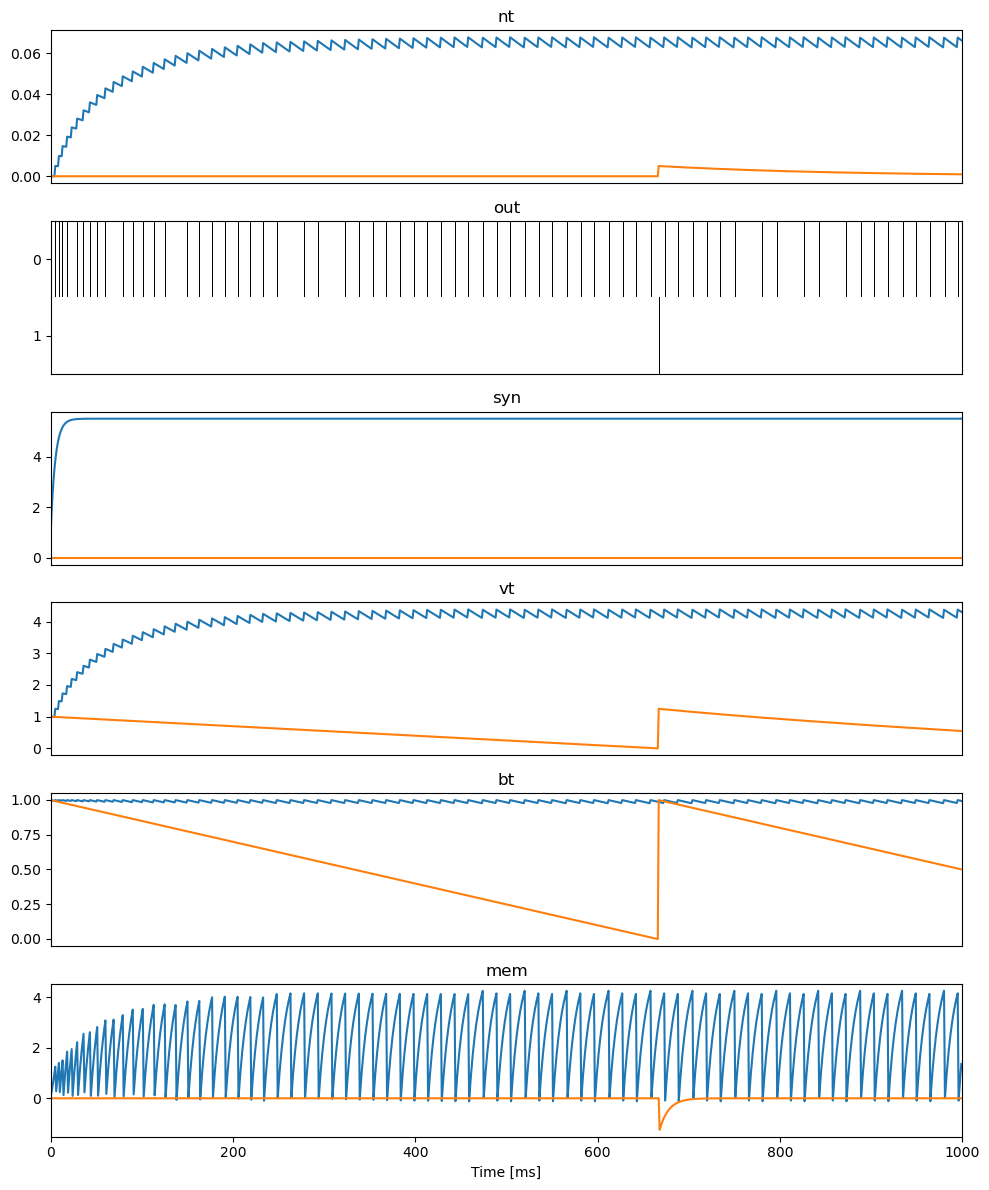

In [8]:
inpt = torch.randn(T, batch_size, n_neurons, device=device, dtype=torch.float32) * 1
inpt = torch.Tensor([[1, 0]]).unsqueeze(0).repeat(T, 1, 1).to(device)
inpt = torch.Tensor([[1, 0]] * T).to(device)


alif.reset_state(batch_size=batch_size)
for i in range(T):
    alif.input = inpt[i]
    alif.evolve()

plot_sequences(alif)


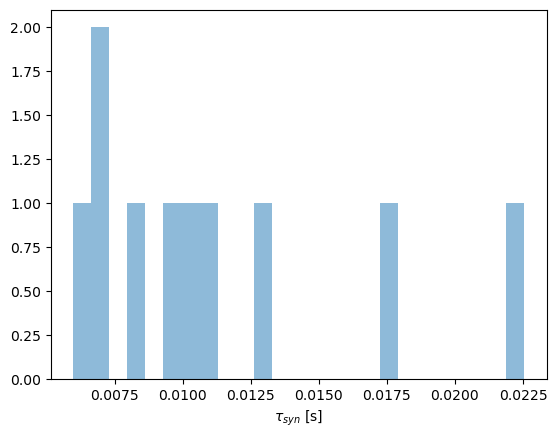

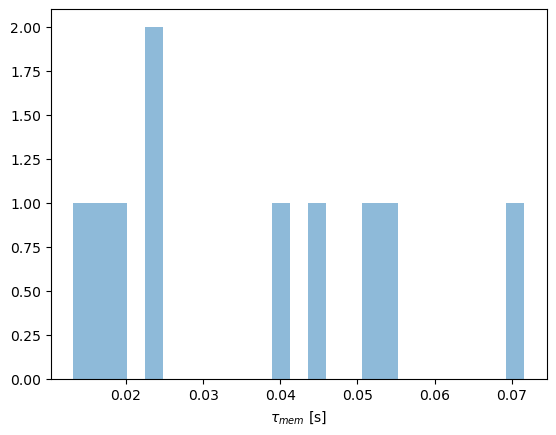

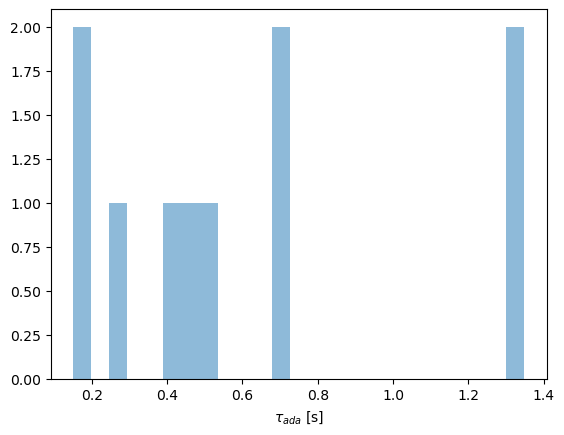

In [9]:
# it seems the time constants are learned well. Now let's explore some initialization options

def get_tau_from_exponential(rate, n, offset=0, seed=None, plot=True, name=''):
    if seed is not None:
        torch.manual_seed(seed)
    dist = torch.distributions.exponential.Exponential(rate=rate)
    tau = dist.sample((n,))
    tau += offset
    if plot:
        plt.hist(tau, bins=25, alpha=0.5)
        label = r'$\tau$' if name == '' else name
        plt.xlabel(label + ' [s]')
        plt.show()

    return tau

N = 10
rate_tau_syn = 200
rate_tau_mem = 20
rate_tau_ada = 2
offset_tau_syn = 0.005           # unit is seconds
offset_tau_mem = 0.010           # unit is seconds
offset_tau_ada = 0.100           # unit is seconds

tau_mem_true = get_tau_from_exponential(rate=rate_tau_syn, n=N, offset=offset_tau_syn, seed=0, name=r'$\tau_{syn}$')
tau_syn_true = get_tau_from_exponential(rate=rate_tau_mem, n=N, offset=offset_tau_mem, seed=1, name=r'$\tau_{mem}$')
tau_ada_true = get_tau_from_exponential(rate=rate_tau_ada, n=N, offset=offset_tau_ada, seed=2, name=r'$\tau_{ada}$')

In [10]:
alif = ALIFGroup(
    shape=N,
    tau_mem=tau_mem_true,
    tau_syn=tau_syn_true,
    tau_ada=tau_ada_true,
    threshold=1.0,
    threshold_decay=torch.rand(N) * 10,
    threshold_xi=torch.rand(N) * 50.0,
    learn_mem=True,
    learn_syn=True,
    learn_ada=True,
    learn_param='tau',
    mem_param='full',
    syn_param='full',
    ada_param='full',
    reset='sub',
    diff_reset=False,
    clamp_mem=False,
    activation=activations.SigmoidSpike,
    dropout_p=0.0,
    stateful=False,
    name="ALIFGroup",
    regularizers=None,
    store_sequences=['mem', 'syn', 'out', 'bt', 'nt', 'vt']
)

alif.configure(dt, device, torch.float32)
alif.reset_state()

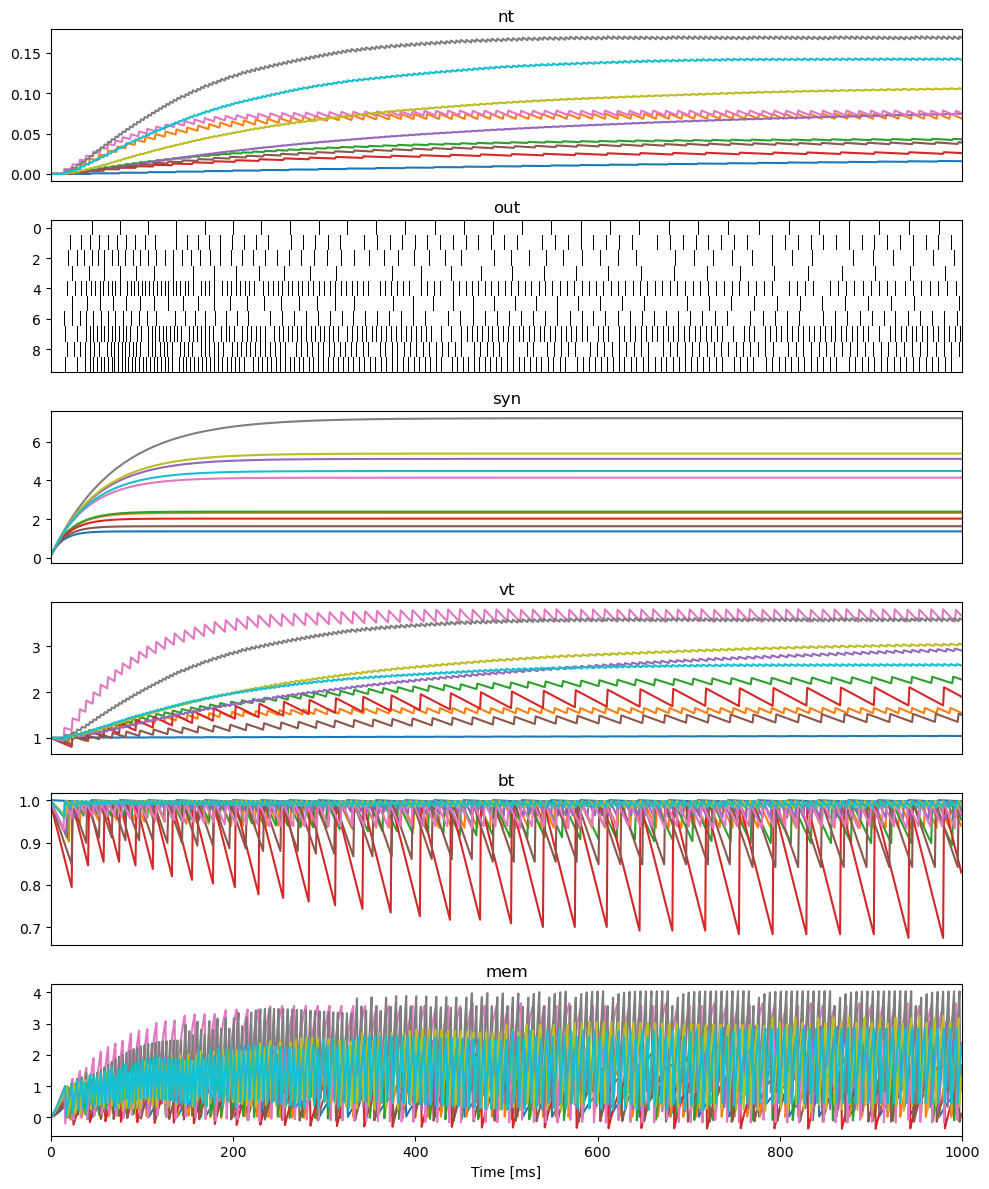

In [11]:
inpt = torch.randn(T, batch_size, N, device=device, dtype=torch.float32) * 0.5
inpt = torch.Tensor([[0.1]]).unsqueeze(0).repeat(T, 1, N).to(device)

alif.reset_state(batch_size=batch_size)
for i in range(T):
    alif.input = inpt[i]
    alif.evolve()

plot_sequences(alif)

In [12]:
from control_stork.models import RecurrentSpikingModel
from control_stork.layers import Layer
from control_stork.nodes import InputGroup, FastLIFGroup, ReadoutGroup
from control_stork.initializers import FluctuationDrivenCenteredNormalInitializer

In [60]:
N = 200
n_in = 100
rate_tau_syn = 200
rate_tau_mem = 20
rate_tau_ada = 2
offset_tau_syn = 0.005           # unit is seconds
offset_tau_mem = 0.010           # unit is seconds
offset_tau_ada = 0.100           # unit is seconds

#tau_mem_true = get_tau_from_exponential(rate=rate_tau_syn, n=N, offset=offset_tau_syn, seed=0, name=r'$\tau_{syn}$')
#tau_syn_true = get_tau_from_exponential(rate=rate_tau_mem, n=N, offset=offset_tau_mem, seed=1, name=r'$\tau_{mem}$')
#tau_ada_true = get_tau_from_exponential(rate=rate_tau_ada, n=N, offset=offset_tau_ada, seed=2, name=r'$\tau_{ada}$')

alif_kwargs = dict(
    tau_mem=0.020,
    tau_syn=0.005,
    tau_ada=0.200,
    threshold=1.0,
    threshold_decay=0, #torch.rand(N) * 0,
    threshold_xi=0, #torch.rand(N) * 0.0,
    learn_mem=True,
    learn_syn=True,
    learn_ada=True,
    learn_param='tau',
    mem_param='full',
    syn_param='single',
    ada_param='full',
    reset='sub',
    diff_reset=False,
    clamp_mem=False,
    activation=activations.SigmoidSpike,
    dropout_p=0.0,
    store_sequences=['mem', 'syn', 'out', 'bt', 'nt', 'vt']
)

lif_kwargs = dict(
    store_sequences=['mem', 'syn', 'out'],
)

rsnn = RecurrentSpikingModel(device=device, dtype=torch.float32)
ini = FluctuationDrivenCenteredNormalInitializer(
    sigma_u=1,
    nu=1,
    time_step=1e-3,
)

layers = []
inp = new = rsnn.add_group(InputGroup(n_in))

for i in range(2):
    new = Layer(
        name=f"Hidden FastLIF {i+1}",
        model=rsnn,
        size=N,
        input_group=inp if i==0 else new.output_group,
        recurrent=True,
        neuron_class=FastLIFGroup,
        # neuron_kwargs=dict(
        #     #tau_mem=get_tau_from_exponential(rate=rate_tau_mem, n=N, offset=offset_tau_mem, seed=0, name=r'$\tau_{syn}$', plot=False),
        #     #tau_syn=get_tau_from_exponential(rate=rate_tau_syn, n=N, offset=offset_tau_syn, seed=1, name=r'$\tau_{syn}$', plot=False),
        #     tau_ada=0.1, #get_tau_from_exponential(rate=rate_tau_ada, n=N, offset=offset_tau_ada, seed=2, name=r'$\tau_{syn}$', plot=False),
        #     threshold=1.0,
        #     threshold_decay=0.0, #torch.rand(N) * 0,
        #     threshold_xi=0.0, #torch.rand(N) * 0.0,
        #     learn_mem=True,
        #     learn_syn=True,
        #     learn_ada=False,
        #     learn_param='tau',
        #     mem_param='full',
        #     syn_param='full',
        #     ada_param='single',
        #     reset='sub',
        #     diff_reset=False,
        #     clamp_mem=False,
        #     activation=activations.SigmoidSpike,
        #     dropout_p=0.0,
        #     store_sequences=[], #['input', 'mem', 'syn', 'out', 'bt', 'nt', 'vt']
        # ),
        connection_kwargs={'bias':True}
    )
    layers.append(new)
#new = Layer(
#        name=f"Hidden ALIF 1",
#         model=rsnn,
#         size=N,
#         input_group=new.output_group,
#         recurrent=True,
#         neuron_class=ALIFGroup,
#         neuron_kwargs=alif_kwargs,
#         connection_kwargs={'bias':True}
# )
#layers.append(new)
out = Layer(
    name="Output Layer",
    model=rsnn,
    input_group=new.output_group,
    size=2,
    recurrent=False,
    neuron_class=ReadoutGroup
)
layers.append(out)
rsnn.configure(inp, out.output_group)
#print("before initialization")
#for c in rsnn.connections:
#    print(c, c.op.weight.shape)
for l in layers:
    ini.initialize(l)
# rsnn = rsnn.to(device)
#print("after initialization")
#for c in rsnn.connections:
#    print(c, c.op.weight.shape)
rsnn.summary()



# Model summary

## Groups
Input, (100,)
Hidden FastLIF 1, (200,)
Hidden FastLIF 2, (200,)
Output Layer, (2,)

## Connections
Connection(
  (src): InputGroup() Input
  (dst): FastLIFGroup() Hidden FastLIF 1
  (op): Linear(in_features=100, out_features=200, bias=True)
) 
Connection(
  (src): FastLIFGroup() Hidden FastLIF 1
  (dst): FastLIFGroup() Hidden FastLIF 1
  (op): Linear(in_features=200, out_features=200, bias=True)
) 
Connection(
  (src): FastLIFGroup() Hidden FastLIF 1
  (dst): FastLIFGroup() Hidden FastLIF 2
  (op): Linear(in_features=200, out_features=200, bias=True)
) 
Connection(
  (src): FastLIFGroup() Hidden FastLIF 2
  (dst): FastLIFGroup() Hidden FastLIF 2
  (op): Linear(in_features=200, out_features=200, bias=True)
) 
Connection(
  (src): FastLIFGroup() Hidden FastLIF 2
  (dst): ReadoutGroup() Output Layer
  (op): Linear(in_features=200, out_features=2, bias=False)
) 

## Trainable Parameters
Total number of trainable parameters: 141200
Number of parameter objects: 9


In [61]:
# make an input tensor with two elements, one being sin, the other cos
T = 500
t = torch.linspace(0, 8*np.pi, T)
inpt = torch.stack([torch.sin(t), torch.cos(t)], dim=1).unsqueeze(0).to(device)

m = torch.randn(n_in, 2).to(device)
inpt_enc = torch.nn.functional.relu(inpt@m.T)

rsnn.reset_state()
res = rsnn(inpt_enc)

In [28]:
for l in rsnn.groups[1:-1]:
    print(l.name)
    print(torch.mean(l.get_out_sequence()))
    plot_sequences(l)

Hidden FastLIF 1


KeyError: 'out'

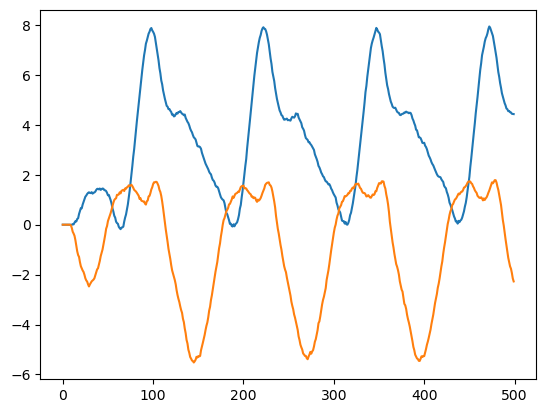

In [62]:
plt.plot(res.squeeze(0).detach().cpu().numpy())
plt.show()

In [63]:
optim = torch.optim.Adam([p for p in rsnn.parameters()])

0 15.209905624389648


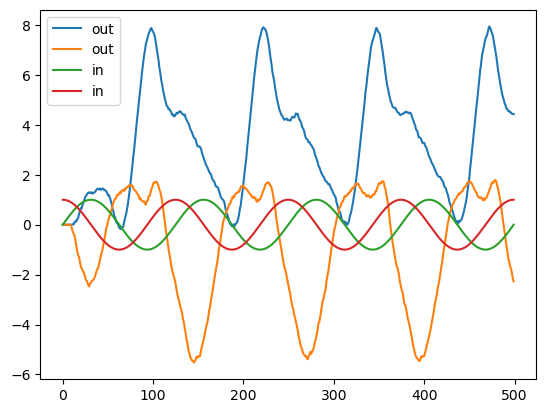

1 5.016227722167969
2 6.202465057373047
3 4.757476806640625
4 2.455120325088501
5 2.157066583633423
6 3.5189154148101807
7 4.266988277435303
8 3.772364616394043
9 2.7157390117645264
10 1.7993160486221313


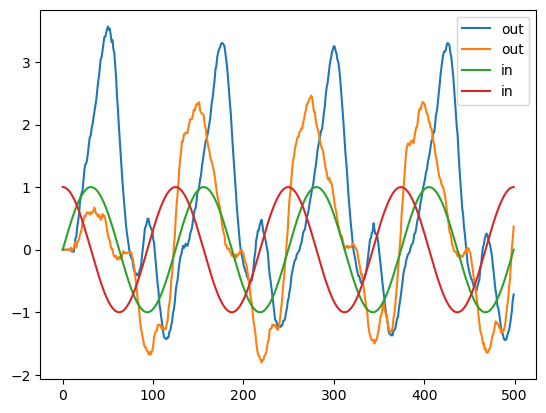

11 1.3419746160507202
12 1.2497433423995972
13 1.3633776903152466
14 1.4976675510406494
15 1.468822956085205
16 1.5406516790390015
17 1.623334288597107
18 1.6268415451049805
19 1.6119965314865112
20 1.4414901733398438


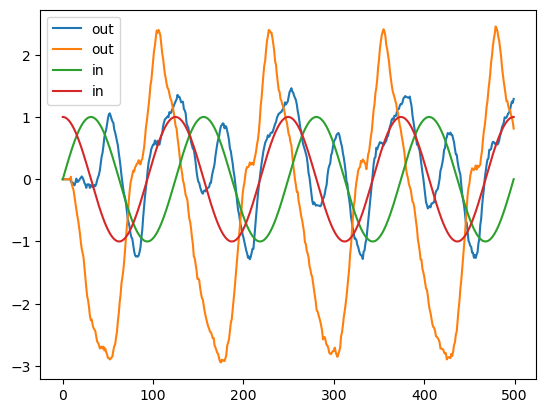

21 1.212607979774475
22 0.9698513746261597
23 0.7938662767410278
24 0.7540695667266846
25 0.6992567777633667
26 0.7498281598091125
27 0.8546097278594971
28 0.9321401119232178
29 0.993088960647583
30 1.0148955583572388


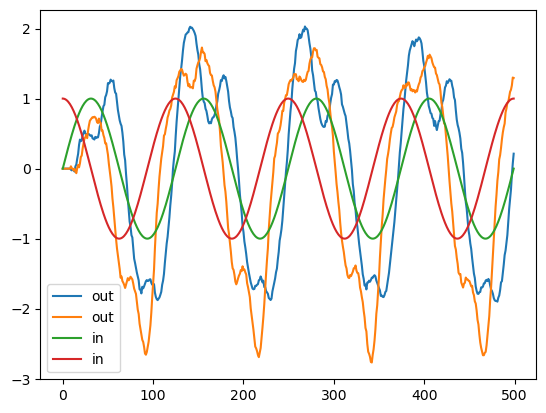

31 0.9581743478775024
32 0.8867397904396057
33 0.8052507638931274
34 0.7539803385734558
35 0.6729316711425781
36 0.6084858775138855
37 0.554172694683075
38 0.5112485289573669
39 0.4926531910896301
40 0.49838632345199585


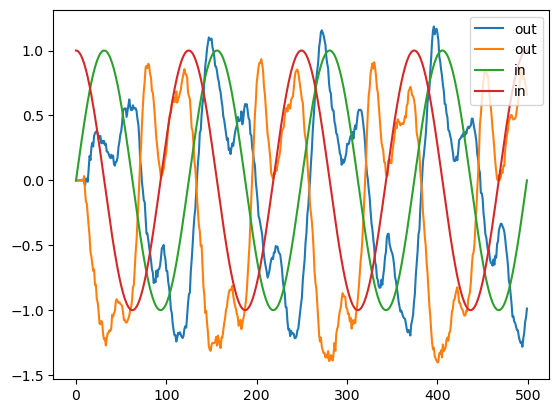

41 0.508806586265564
42 0.5450190901756287
43 0.5479376316070557
44 0.554685115814209
45 0.5483828783035278
46 0.5299789309501648
47 0.5199791789054871
48 0.49371886253356934
49 0.44203245639801025


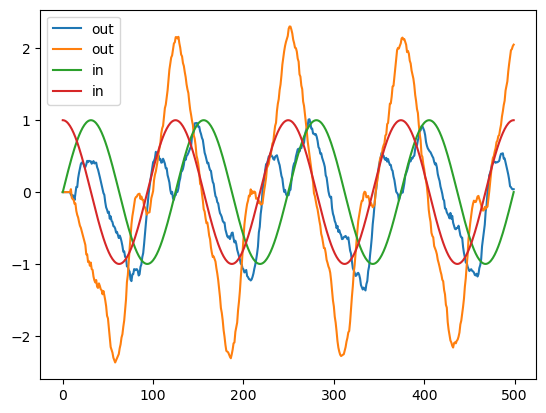

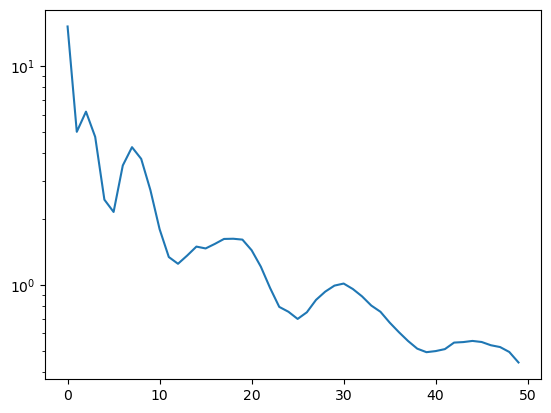

In [64]:
losses = []
for i in range(50):
    rsnn.reset_state()
    res = rsnn(inpt_enc)

    optim.zero_grad()
    loss = torch.nn.functional.mse_loss(inpt[:, 100:], res[:, 100:])
    loss.backward()
    optim.step()

    print(i, loss.item())
    losses.append(loss.item())

    if i % 10 == 0:

        plt.plot(res.squeeze(0).detach().cpu().numpy(), label='out')
        plt.plot(inpt.squeeze(0).detach().cpu().numpy(), label='in')
        plt.legend()
        plt.show()

plt.plot(res.squeeze(0).detach().cpu().numpy(), label='out')
plt.plot(inpt.squeeze(0).detach().cpu().numpy(), label='in')
plt.legend()
plt.show()

plt.plot(losses)
plt.yscale('log')
plt.show()


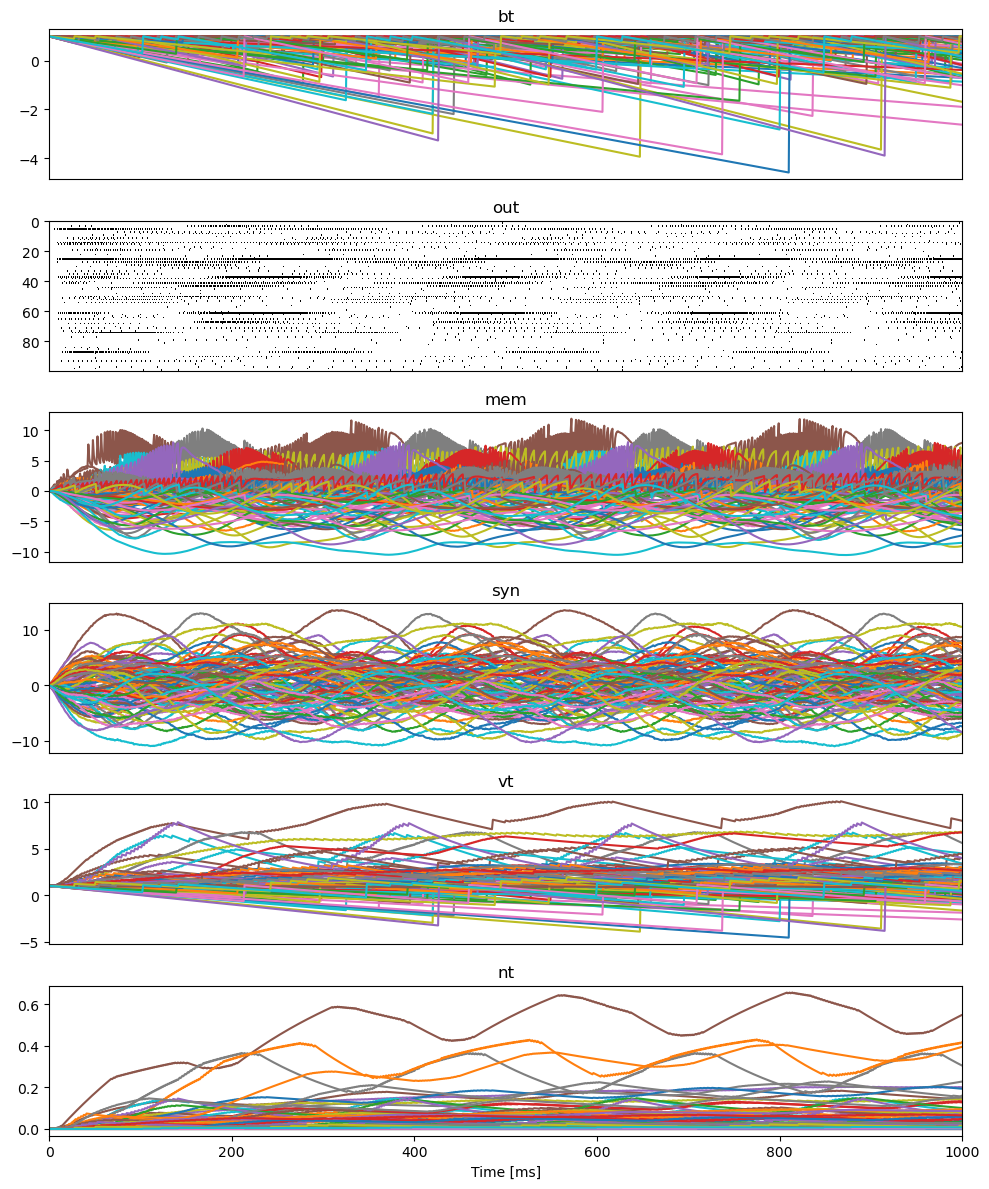

In [20]:
plot_sequences(rsnn.groups[2])